In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
api = wandb.Api()

# Specify the run you want to load daata from

# From scratch model
hyperdas_path = "jiudingsun/HyperDAS/nrxbl401" 

timezone_path = "jiudingsun/HyperDAS/ti9b21j3"
language_path = "jiudingsun/HyperDAS/ye7gc54e"
longtitude_path = "jiudingsun/HyperDAS/ajz8682p"
latitude_path = "jiudingsun/HyperDAS/l6w3d5ak"
country_path = "jiudingsun/HyperDAS/s7rh90s4"
continent_path = "jiudingsun/HyperDAS/xglglxxs"

hyperdas_run = api.run(hyperdas_path)

mdas_timezone_run = api.run(timezone_path)
mdas_language_run = api.run(language_path)
mdas_longtitude_run = api.run(longtitude_path)
mdas_latitude_run = api.run(latitude_path)
mdas_country_run = api.run(country_path)
mdas_continent_run = api.run(continent_path)

In [66]:
hyperdas_history = hyperdas_run.scan_history()
hyperdas_history = pd.DataFrame(hyperdas_history)

hyperdas_history = hyperdas_history[['step', 'bidding_argmax_disentangle_accuracy']]

# drop the row where the 'train_batch_prediction_loss' is NaN
hyperdas_history = hyperdas_history.dropna(subset=['bidding_argmax_disentangle_accuracy'])
hyperdas_history["Method"] = "HyperDAS"
# Assighn the value of step to be the index
for i in hyperdas_history.index:
    hyperdas_history.loc[i, 'step'] = int(i)

hyperdas_history.reset_index(drop=True, inplace=True)

In [67]:
hyperdas_history

,step,bidding_argmax_disentangle_accuracy,Method
0,0.0,0.495347,HyperDAS
1,2002.0,0.644757,HyperDAS
2,4005.0,0.699524,HyperDAS
3,6008.0,0.734632,HyperDAS
4,8011.0,0.738741,HyperDAS
5,10013.0,0.742952,HyperDAS
6,12016.0,0.735820,HyperDAS


In [70]:
mdas_runs = [mdas_timezone_run, mdas_language_run, mdas_longtitude_run, mdas_latitude_run, mdas_country_run, mdas_continent_run]
mdas_histories = []

for run in mdas_runs:
    mdas_history = run.scan_history()
    mdas_history = pd.DataFrame(mdas_history)
    mdas_history = mdas_history[['step', 'train_batch_prediction_loss', 'disentangle_accuracy']]
    mdas_history = mdas_history.dropna(subset=['disentangle_accuracy'])
    mdas_histories.append(mdas_history)

In [71]:
all_mdas_index = []
for i in range(len(mdas_histories)):
    all_mdas_index.extend(mdas_histories[i].index)

all_mdas_index = sorted(list(set(all_mdas_index)))
mdas_df = pd.DataFrame(columns=['step', 'bidding_argmax_disentangle_accuracy', 'Method'])

last_disentangle_accuracy = [0, 0, 0, 0, 0, 0]

total_steps = 0
last_i = 0
for i in all_mdas_index:
    all_attributes_with_that_index = []
    for j in range(len(mdas_histories)):
        if i in mdas_histories[j].index:
            all_attributes_with_that_index.append(j)
    
    for j in range(len(mdas_histories)):
        if j in all_attributes_with_that_index:
            last_disentangle_accuracy[j] = mdas_histories[j].loc[i, 'disentangle_accuracy']
    
    total_steps += (i - last_i) * len(all_attributes_with_that_index)
    current_disentangle_accuracy = sum(last_disentangle_accuracy) / len(last_disentangle_accuracy)
    mdas_df.loc[len(mdas_df)] = [total_steps, current_disentangle_accuracy, "MDAS"]
    
    last_i = i
        
    

In [80]:
df = pd.concat([hyperdas_history, mdas_df])
df = df[df['step'] < 12500]

(0.0, 12500.0)

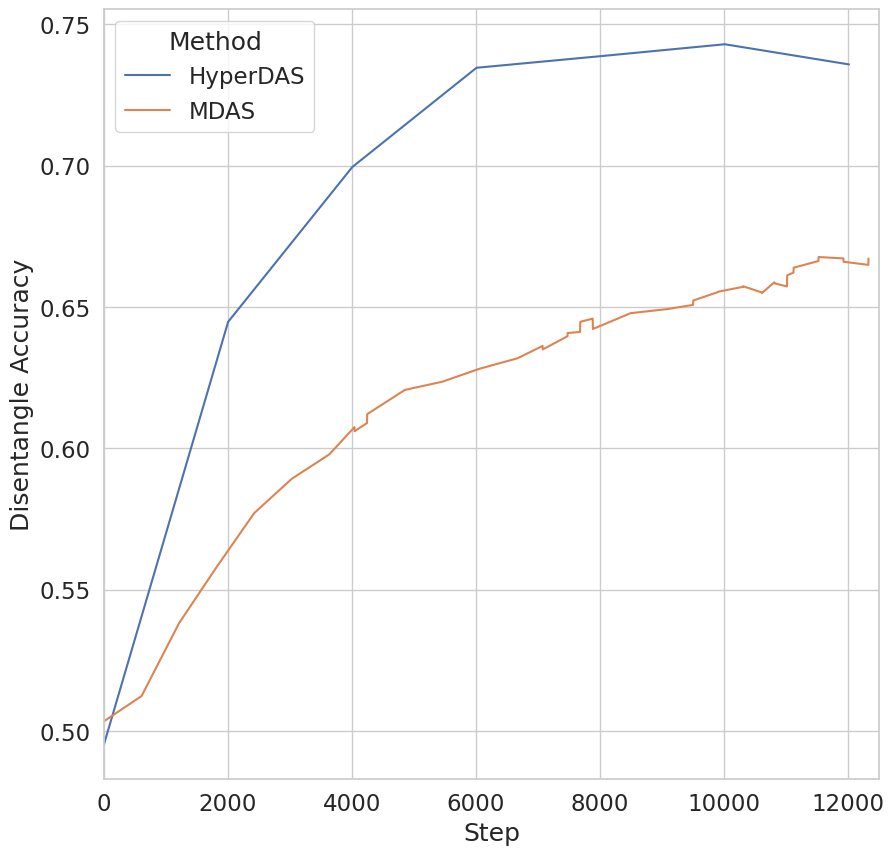

In [ ]:
# Plot the training loss per step
sns.set(style='whitegrid', font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.lineplot(x='step', y='bidding_argmax_disentangle_accuracy', hue='Method', data=df)

plt.xlabel('Step')
plt.ylabel('Disentangle Accuracy')

plt.tight_layout()

plt.savefig("mdas_hyperdas_convergence.pdf")

plt.xlim(0, 12500)